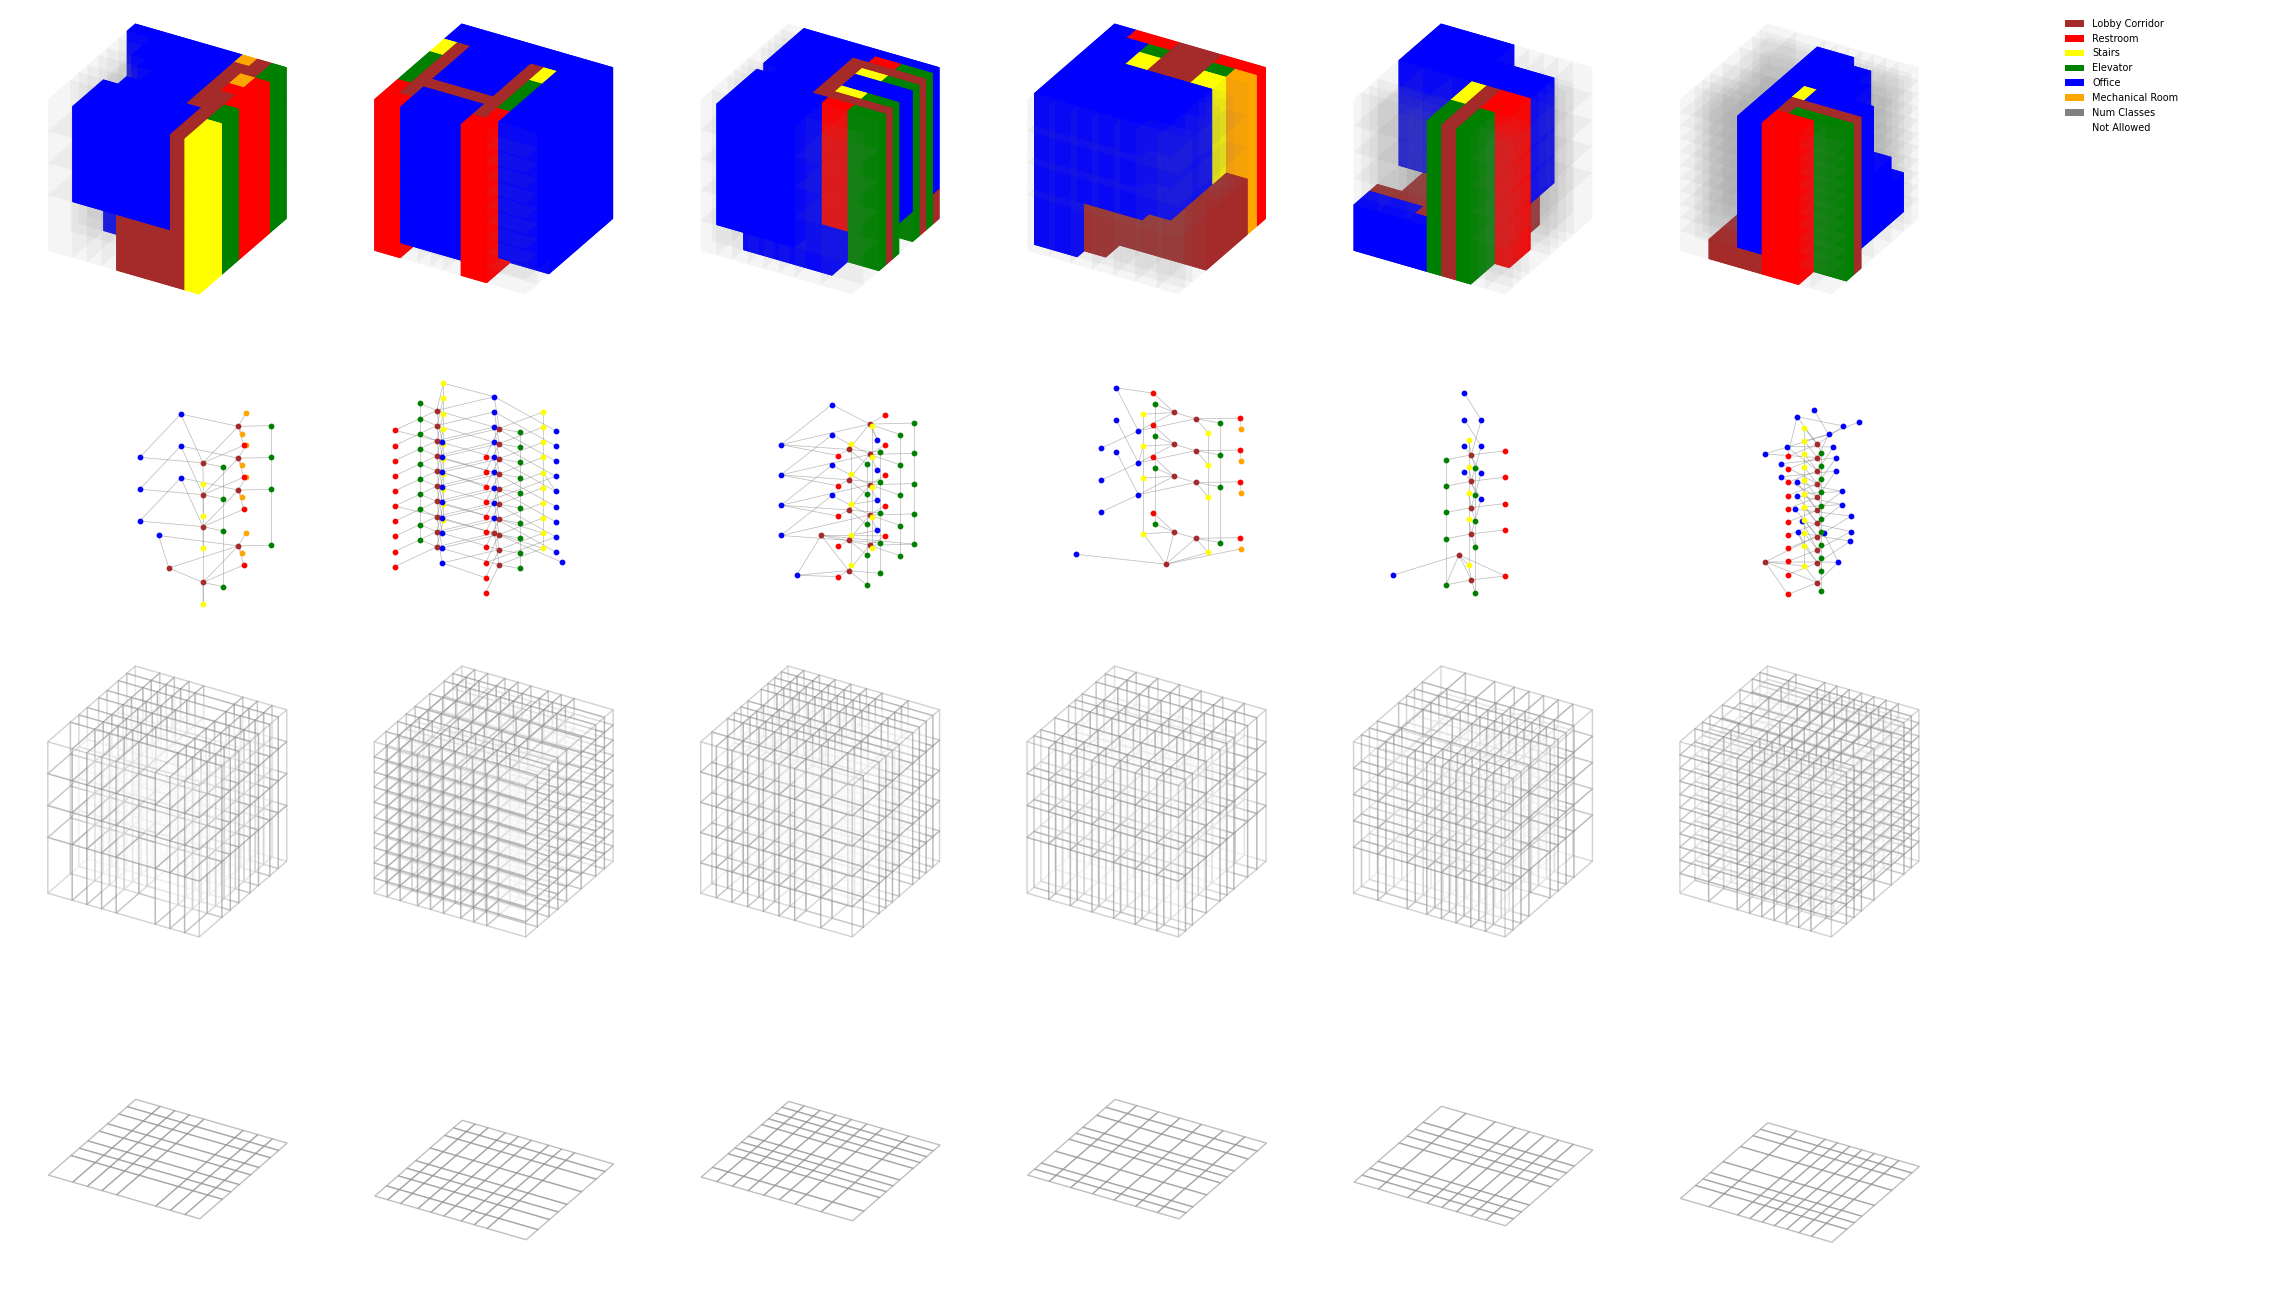

In [1]:
# %matplotlib ipympl

import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

from typing import Hashable
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

from building_gan.src import config

data_path_base = "../data/6types-raw_data"
data_path_base_voxel = os.path.join(data_path_base, "voxel_data", "voxel_")
data_path_base_local_graph = os.path.join(data_path_base, "local_graph_data", "graph_local_")
data_points = [
    "004001.json",
    "005002.json",
    "006666.json",
    "007777.json",
    "008888.json",
    "009955.json",
]

col = len(data_points) + 1
row = 4

fig = plt.figure(figsize=(23, 13))

for di, data_point in enumerate(data_points):
    
    ax = fig.add_subplot(row, col, di + 1, projection="3d")
    ax_graph_local = fig.add_subplot(row, col, di + col + 1, projection="3d")
    ax_voxel_grid = fig.add_subplot(row, col, di + col * 2 + 1, projection="3d")
    ax_voxel_grid_bottom = fig.add_subplot(row, col, di + col * 3 + 1, projection="3d")
    
    # visualize voxel data
    voxel_data_path = data_path_base_voxel + data_point
    with open(voxel_data_path, "r") as f:
        voxel_data = json.load(f)

    for node in voxel_data["voxel_node"]:
        z_coo, y_coo, x_coo = node["coordinate"]
        z_dim, y_dim, x_dim = node["dimension"]
        floor_num, _, _ = node["location"]
        voxel_type = node["type"]
        if voxel_type == config.ProgramMap.VOID_OLD:
            voxel_type = config.ProgramMap.VOID
        elif voxel_type == config.ProgramMap.NOT_ALLOWED_OLD:
            voxel_type = config.ProgramMap.NOT_ALLOWED
        
        voxel_vertices = [
            [x_coo, y_coo, z_coo], 
            [x_coo+x_dim, y_coo, z_coo], 
            [x_coo+x_dim, y_coo+y_dim, z_coo], 
            [x_coo, y_coo+y_dim, z_coo],
            [x_coo, y_coo, z_coo+z_dim], 
            [x_coo+x_dim, y_coo, z_coo+z_dim], 
            [x_coo+x_dim, y_coo+y_dim, z_coo+z_dim], 
            [x_coo, y_coo+y_dim, z_coo+z_dim]
        ]
        
        voxel_faces = [
            [voxel_vertices[0], voxel_vertices[1], voxel_vertices[2], voxel_vertices[3]],
            [voxel_vertices[4], voxel_vertices[5], voxel_vertices[6], voxel_vertices[7]],
            [voxel_vertices[0], voxel_vertices[1], voxel_vertices[5], voxel_vertices[4]],
            [voxel_vertices[2], voxel_vertices[3], voxel_vertices[7], voxel_vertices[6]],
            [voxel_vertices[1], voxel_vertices[2], voxel_vertices[6], voxel_vertices[5]],
            [voxel_vertices[0], voxel_vertices[3], voxel_vertices[7], voxel_vertices[4]]
        ]
        
        voxel_grid = Poly3DCollection(voxel_faces, alpha=0.2)
        voxel_grid.set_facecolor("white")
        voxel_grid.set_edgecolor("gray")
        ax_voxel_grid.add_collection3d(voxel_grid)
        
        voxel_color_alpha = 0.035 if voxel_type in (6, 7) else 1.0
        voxel = Poly3DCollection(voxel_faces, alpha=voxel_color_alpha)
        voxel.set_facecolor(config.ProgramMap.COLORS[voxel_type])
        ax.add_collection3d(voxel)
        
        # visualize irrgeular grid
        if floor_num == 0:
            for v in voxel_faces[0]:
                v[2] += 5
                
            bottom_face = [voxel_faces[0]]
            voxel_grid_bottom_face = Poly3DCollection(bottom_face, alpha=0.5)
            voxel_grid_bottom_face.set_facecolor("white")
            voxel_grid_bottom_face.set_edgecolor("gray")
            ax_voxel_grid_bottom.add_collection3d(voxel_grid_bottom_face)
        
    # visualize local graph data        
    graph_local_data_path = data_path_base_local_graph + data_point
    with open(graph_local_data_path, "r") as f:
        local_graph_data = json.load(f)
        
    nodes = local_graph_data["node"]
    for ni, node in enumerate(nodes):
        z_cen, y_cen, x_cen = node["center"]
        node_type = node["type"]
        
        ax_graph_local.scatter(
            x_cen, 
            y_cen, 
            z_cen, 
            c=[config.ProgramMap.COLORS[node_type]], 
            s=10
        )
        
        for neighbor in node["neighbors"]:
            neighbor_node = None
            for n in nodes:
                if (
                    n["floor"] == neighbor[0] 
                    and n["type"] == neighbor[1] 
                    and n["type_id"] == neighbor[2]
                ):
                    neighbor_node = n
                    
            assert neighbor_node is not None

            z_neighbor, y_neighbor, x_neighbor = neighbor_node["center"]
            ax_graph_local.plot(
                [x_cen, x_neighbor], 
                [y_cen, y_neighbor], 
                [z_cen, z_neighbor], 
                color="gray", 
                alpha=0.3, 
                linewidth=0.5
            )

    ax.set_box_aspect([1, 1, 1])
    ax.set_proj_type("ortho")
    ax._axis3don = False

    ax_voxel_grid.set_box_aspect([1, 1, 1])
    ax_voxel_grid.set_proj_type("ortho")
    ax_voxel_grid._axis3don = False

    ax_voxel_grid_bottom.set_box_aspect([1, 1, 1])
    ax_voxel_grid_bottom.set_proj_type("ortho")
    ax_voxel_grid_bottom._axis3don = False
    
    ax_graph_local.set_box_aspect([1, 1, 1])
    ax_graph_local.set_proj_type("ortho")
    ax_graph_local._axis3don = False

    # auto-scale the plot
    all_coords = np.array([node["coordinate"] for node in voxel_data["voxel_node"]])
    all_dims = np.array([node["dimension"] for node in voxel_data["voxel_node"]])
    max_coords = np.max(all_coords + all_dims, axis=0)
    min_coords = np.min(all_coords, axis=0)

    ax.set_xlim(min_coords[2], max_coords[2])
    ax.set_ylim(min_coords[1], max_coords[1])
    ax.set_zlim(min_coords[0], max_coords[0])

    ax_voxel_grid.set_xlim(min_coords[2], max_coords[2])
    ax_voxel_grid.set_ylim(min_coords[1], max_coords[1])
    ax_voxel_grid.set_zlim(min_coords[0], max_coords[0])

    ax_voxel_grid_bottom.set_xlim(min_coords[2], max_coords[2])
    ax_voxel_grid_bottom.set_ylim(min_coords[1], max_coords[1])
    ax_voxel_grid_bottom.set_zlim(min_coords[0], max_coords[0])
    
    ax_graph_local.set_xlim(min_coords[2], max_coords[2])
    ax_graph_local.set_ylim(min_coords[1], max_coords[1])
    ax_graph_local.set_zlim(min_coords[0], max_coords[0])
    
    # plot legends
    if di == len(data_points) - 1:
        
        program_map_reversed = {v: k for k, v in config.ProgramMap.__dict__.items() if isinstance(v, Hashable)}
        
        ax_legend = fig.add_subplot(row, col, di + 2, projection="3d")
        ax_legend.legend(
            handles=[
                Patch(
                    facecolor=config.ProgramMap.COLORS[program], 
                    label=program_map_reversed[program].replace("_", " ").title(),
                )
                for program in config.ProgramMap.COLORS.keys()
            ], 
            fontsize=7,
            frameon=False,
            loc="upper center",
        )
    
        ax_legend.set_box_aspect([1, 1, 1])
        ax_legend.set_proj_type("ortho")
        ax_legend._axis3don = False
        
plt.tight_layout()
plt.show()